In [ ]:
import os
import pandas as pd
from pathlib import Path
import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Suppress warnings
warnings.filterwarnings('ignore')


def basic_eda(file_path):
    """
    Perform basic EDA on a CSV file and print the results.
    """
    print(f"\n{'='*80}")
    print(f"ANALYZING: {file_path}")
    print(f"{'='*80}")
    
    
    try:
        # Get file size
        file_size = os.path.getsize(file_path) / (1024 * 1024)  # Convert to MB
        print(f"\nFile size: {file_size:.2f} MB")
        
        # Read the first few rows
        df = pd.read_csv(file_path, nrows=5)
        
        # Display basic info
        print("\nFirst 5 rows:")
        display(df.head())
        
        # Read full file for dimensions
        df_full = pd.read_csv(file_path)
        
        # Display dimensions
        print(f"\nDimensions: {df_full.shape[0]} rows x {df_full.shape[1]} columns")
        
        # Display column names and data types
        print("\nColumn names and data types:")
        print(df_full.dtypes)
        
        # Basic statistics for numeric columns
        print("\nBasic statistics:")
        print(df_full.describe(include='all'))
        
        # Check for missing values
        print("\nMissing values per column:")
        print(df_full.isnull().sum())
        
    except Exception as e:
        print(f"Error analyzing {file_path}: {str(e)}")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

def plot_numeric_relationships_from_csv(file_path, figsize=(15, 12), corr_threshold=0.7, **read_csv_kwargs):
    """
    Visualiza las relaciones entre variables numéricas de un archivo CSV mediante:
    1. Matriz de dispersión con histogramas en la diagonal
    2. Matriz de correlación con mapa de calor
    
    Parámetros:
    -----------
    file_path : str
        Ruta al archivo CSV
    figsize : tuple, opcional
        Tamaño de la figura (ancho, alto)
    corr_threshold : float, opcional
        Umbral para resaltar correlaciones fuertes
    **read_csv_kwargs : dict, opcional
        Argumentos adicionales para pd.read_csv()
    """
    # Verificar si el archivo existe
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"No se encontró el archivo: {file_path}")
    
    try:
        # Leer el archivo CSV
        df = pd.read_csv(file_path, **read_csv_kwargs)
        print(f"Archivo cargado exitosamente: {os.path.basename(file_path)}")
        print(f"Forma del DataFrame: {df.shape[0]} filas x {df.shape[1]} columnas")
        
        # Seleccionar solo columnas numéricas
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        
        if len(numeric_cols) < 2:
            print("No hay suficientes columnas numéricas para el análisis")
            return None
        
        # Crear una copia del DataFrame con solo las columnas numéricas
        df_numeric = df[numeric_cols].copy()
        
        # Configurar el estilo de los gráficos
        sns.set(style="whitegrid")
        
        # 1. Matriz de dispersión con histogramas en la diagonal
        print("\nGenerando matriz de dispersión...")
        plt.figure(figsize=figsize)
        scatter_matrix = sns.pairplot(df_numeric, diag_kind='hist', 
                                    plot_kws={'alpha': 0.6, 's': 20, 'edgecolor': 'k'},
                                    diag_kws={'alpha': 0.8, 'edgecolor': 'k', 'bins': 15})
        
        # Ajustar el espaciado
        plt.subplots_adjust(top=0.95)
        scatter_matrix.fig.suptitle(f'Matriz de dispersión: {os.path.basename(file_path)}', y=1.02)
        plt.show()
        
        # 2. Matriz de correlación con mapa de calor
        print("\nGenerando matriz de correlación...")
        fig, ax = plt.subplots(figsize=figsize)
        
        # Calcular matriz de correlación
        corr = df_numeric.corr()
        
        # Crear máscara para el triángulo superior
        mask = np.triu(np.ones_like(corr, dtype=bool))
        
        # Crear mapa de calor
        cmap = sns.diverging_palette(230, 20, as_cmap=True)
        sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                    square=True, linewidths=.5, cbar_kws={"shrink": .8}, 
                    annot=True, fmt=".2f", annot_kws={"size": 10}, ax=ax)
        
        # Resaltar correlaciones fuertes
        strong_corr = (corr.abs() > corr_threshold) & (corr.abs() < 1.0)
        
        # Añadir anotaciones para correlaciones fuertes
        for i in range(len(corr)):
            for j in range(len(corr)):
                if strong_corr.iloc[i, j]:
                    ax.text(j + 0.5, i + 0.5, f'{corr.iloc[i, j]:.2f}',
                           ha='center', va='center', fontsize=10,
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
        
        plt.title(f'Matriz de correlación: {os.path.basename(file_path)}\n(|r| > {corr_threshold} resaltado)', pad=20)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
        
        return df_numeric
        
    except Exception as e:
        print(f"Error al procesar el archivo {file_path}: {str(e)}")
        return None


def convert_low_cardinality_numeric_to_categorical(df, max_unique=50, inplace=False):
    """
    Convierte columnas numéricas con baja cardinalidad a tipo categórico.
    
    Parámetros:
    -----------
    df : pandas.DataFrame
        DataFrame de entrada
    max_unique : int, opcional (default=50)
        Número máximo de valores únicos para considerar conversión a categórica
    inplace : bool, opcional (default=False)
        Si es True, modifica el DataFrame original. Si es False, devuelve una copia.
        
    Retorna:
    --------
    pandas.DataFrame
        DataFrame con las columnas convertidas a categóricas cuando corresponde
    """
    if not inplace:
        df = df.copy()
    
    # Identificar columnas numéricas
    numeric_cols = df.select_dtypes(include=['int', 'float']).columns.tolist()
    
    # Contador para las columnas convertidas
    converted_cols = 0
    
    for col in numeric_cols:
        # Obtener el número de valores únicos
        n_unique = df[col].nunique()
        
        # Verificar si cumple con el criterio de baja cardinalidad
        if 1 < n_unique <= max_unique and n_unique < len(df) * 0.1:  # Máximo 10% de valores únicos
            # Convertir a categoría
            df[col] = df[col].astype('category')
            converted_cols += 1
            print(f"Convertida columna '{col}' a categórica ({n_unique} valores únicos)")
    
    print(f"\nTotal de columnas convertidas: {converted_cols} de {len(numeric_cols)} columnas numéricas")
    
    if not inplace:
        return df


from typing import List, Optional
import os

def plot_categorical_distribution_from_csv(
    file_path: str,
    columns: Optional[List[str]] = None,
    figsize: tuple = (15, 5),
    max_categories: int = 20,
    rotation: int = 45,
    palette: str = "viridis",
    sort_by: str = "frequency",
    horizontal: bool = False,
    show_values: bool = True,
    value_format: str = ".1f",
    title: Optional[str] = None,
    font_size_axis: int = 12,
    **read_csv_kwargs
) -> Optional[pd.DataFrame]:
    """
    Visualiza la distribución de variables categóricas desde un archivo CSV.
    
    Parámetros:
    -----------
    file_path : str
        Ruta al archivo CSV
    columns : list, opcional
        Lista de columnas categóricas a visualizar. Si es None, usa todas las categóricas
    figsize : tuple, opcional
        Tamaño de la figura (ancho, alto)
    max_categories : int, opcional
        Número máximo de categorías a mostrar por variable
    rotation : int, opcional
        Rotación de las etiquetas del eje x
    palette : str, opcional
        Paleta de colores de seaborn
    sort_by : str, opcional
        Ordenar por 'frequency' (frecuencia) o 'name' (nombre)
    horizontal : bool, opcional
        Si es True, muestra las barras horizontalmente
    show_values : bool, opcional
        Si es True, muestra los valores en las barras
    value_format : str, opcional
        Formato para mostrar los valores (ej: '.0f' para enteros, '.1%' para porcentajes)
    title : str, opcional
        Título general para todos los gráficos
    **read_csv_kwargs : dict, opcional
        Argumentos adicionales para pd.read_csv()
        
    Retorna:
    --------
    pd.DataFrame o None
        DataFrame con los datos leídos o None si hubo un error
    """
    try:
        # Verificar si el archivo existe
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"No se encontró el archivo: {file_path}")
            
        # Leer el archivo CSV
        df = pd.read_csv(file_path, **read_csv_kwargs)
        print(f"Archivo cargado exitosamente: {os.path.basename(file_path)}")
        print(f"Forma del DataFrame: {df.shape[0]} filas x {df.shape[1]} columnas")
        
        # Si no se especifican columnas, usar todas las categóricas
        if columns is None:
            cat_cols = df.select_dtypes(include=['category', 'object', 'bool']).columns.tolist()
        else:
            cat_cols = [col for col in columns if col in df.columns]
        
        if not cat_cols:
            print("No se encontraron columnas categóricas para graficar.")
            return df
        
        # Si hay muchas columnas, ajustar el tamaño de la figura
        if len(cat_cols) > 4:
            figsize = (figsize[0], figsize[1] * (len(cat_cols) // 2 + 1))
        
        # Configurar estilo
        sns.set_style("whitegrid")
        
        # Calcular el número de filas y columnas para los subplots
        n_cols = 1
        n_rows = (len(cat_cols) + 1) // n_cols
        
        # Crear figura
        fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
        axes = axes.ravel() if isinstance(axes, np.ndarray) else [axes]
        
        # Ajustar el espacio entre subplots
        plt.subplots_adjust(hspace=0.5, wspace=0.3)
        
        # Ocultar ejes que no se usen
        for i in range(len(cat_cols), len(axes)):
            axes[i].axis('off')
        
        # Para cada columna categórica
        for i, col in enumerate(cat_cols):
            ax = axes[i]
            
            # Contar frecuencias
            counts = df[col].value_counts()
            
            # Limitar el número de categorías
            if len(counts) > max_categories:
                top_categories = counts.index[:max_categories-1]
                counts = counts[top_categories]
                counts[f"Otros ({len(df[col].unique()) - max_categories + 1})"] = df[~df[col].isin(top_categories)].shape[0]
            
            # Ordenar
            if sort_by == 'frequency':
                counts = counts.sort_values(ascending=not horizontal)
            
            # Crear gráfico de barras
            if horizontal:
                bars = sns.barplot(x=counts.values, y=counts.index, ax=ax, palette=palette)
                ax.set_xlabel('Frecuencia')
                ax.set_ylabel('')
                
                # Añadir etiquetas de valor
                if show_values:
                    max_val = counts.max()
                    for j, v in enumerate(counts.values):
                        ax.text(v + (0.01 * max_val), j, f"{v:{value_format}}", 
                               va='center')
            else:
                bars = sns.barplot(x=counts.index, y=counts.values, ax=ax, palette=palette)
                ax.set_xlabel('')
                ax.set_ylabel('Frecuencia')
                
                # Rotar etiquetas del eje x
                ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation, ha='right')
                
                # Añadir etiquetas de valor
                if show_values:
                    max_val = counts.max()
                    for j, v in enumerate(counts.values):
                        ax.text(j, v + (0.01 * max_val), f"{v:{value_format}}", 
                               ha='center')
            
            # Ajustar título y etiquetas
            ax.set_title(f"Distribución de '{col}'\n({len(df[col].dropna().unique())} categorías, {df[col].isna().sum()} nulos)", 
                        fontsize=10)
            
            # Ajustar diseño
            plt.tight_layout()
        
        # Ajustar título general si se proporciona
        if title:
            plt.suptitle(f"{title}\nArchivo: {os.path.basename(file_path)}", 
                        y=1.02, fontsize=14)
        else:
            plt.suptitle(f"Análisis de variables categóricas\nArchivo: {os.path.basename(file_path)}", 
                        y=1.02, fontsize=14)
        
        plt.tight_layout()
        plt.show()
        
 
        
    except Exception as e:
        print(f"Error al procesar el archivo {file_path}: {str(e)}")
        return None

### Holydays Events

In [36]:
basic_eda( '../data/raw/holidays_events.csv')


ANALYZING: ../data/raw/holidays_events.csv

File size: 0.02 MB

First 5 rows:


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False



Dimensions: 350 rows x 6 columns

Column names and data types:
date           object
type           object
locale         object
locale_name    object
description    object
transferred      bool
dtype: object

Basic statistics:
              date     type    locale locale_name description transferred
count          350      350       350         350         350         350
unique         312        6         3          24         103           2
top     2014-06-25  Holiday  National     Ecuador    Carnaval       False
freq             4      221       174         174          10         338

Missing values per column:
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64


### Items

In [37]:
basic_eda( '../data/raw/items.csv')


ANALYZING: ../data/raw/items.csv

File size: 0.10 MB

First 5 rows:


,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1



Dimensions: 4100 rows x 4 columns

Column names and data types:
item_nbr       int64
family        object
class          int64
perishable     int64
dtype: object

Basic statistics:
            item_nbr     family      class   perishable
count   4.100000e+03       4100  4100.0000  4100.000000
unique           NaN         33        NaN          NaN
top              NaN  GROCERY I        NaN          NaN
freq             NaN       1334        NaN          NaN
mean    1.251436e+06        NaN  2169.6500     0.240488
std     5.876872e+05        NaN  1484.9109     0.427432
min     9.699500e+04        NaN  1002.0000     0.000000
25%     8.181108e+05        NaN  1068.0000     0.000000
50%     1.306198e+06        NaN  2004.0000     0.000000
75%     1.904918e+06        NaN  2990.5000     0.000000
max     2.134244e+06        NaN  7780.0000     1.000000

Missing values per column:
item_nbr      0
family        0
class         0
perishable    0
dtype: int64


In [2]:
import pandas as pd
items = pd.read_csv("../data/raw/items.csv")

In [5]:
items['class'].value_counts()

1016    133
1040    110
1124    100
1034     98
1122     81
       ... 
2340      1
4139      1
1046      1
6301      1
1328      1
Name: class, Length: 337, dtype: int64

Archivo cargado exitosamente: items.csv
Forma del DataFrame: 4100 filas x 4 columnas


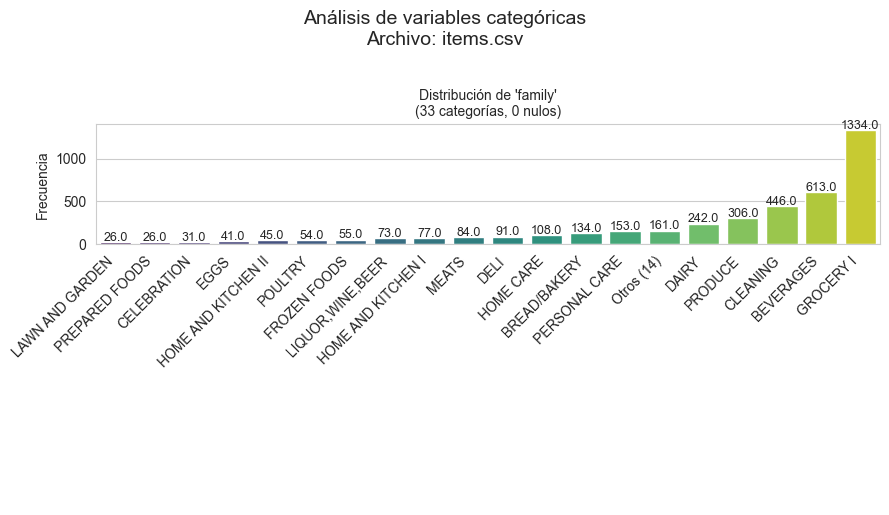

In [21]:
plot_categorical_distribution_from_csv("../data/raw/items.csv",figsize=(9, 5))

### Oil

In [38]:
basic_eda( '../data/raw/oil.csv')


ANALYZING: ../data/raw/oil.csv

File size: 0.02 MB

First 5 rows:


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20



Dimensions: 1218 rows x 2 columns

Column names and data types:
date           object
dcoilwtico    float64
dtype: object

Basic statistics:
              date   dcoilwtico
count         1218  1175.000000
unique        1218          NaN
top     2013-01-01          NaN
freq             1          NaN
mean           NaN    67.714366
std            NaN    25.630476
min            NaN    26.190000
25%            NaN    46.405000
50%            NaN    53.190000
75%            NaN    95.660000
max            NaN   110.620000

Missing values per column:
date           0
dcoilwtico    43
dtype: int64


### Stores

In [39]:
basic_eda( '../data/raw/stores.csv')


ANALYZING: ../data/raw/stores.csv

File size: 0.00 MB

First 5 rows:


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4



Dimensions: 54 rows x 5 columns

Column names and data types:
store_nbr     int64
city         object
state        object
type         object
cluster       int64
dtype: object

Basic statistics:
        store_nbr   city      state type    cluster
count   54.000000     54         54   54  54.000000
unique        NaN     22         16    5        NaN
top           NaN  Quito  Pichincha    D        NaN
freq          NaN     18         19   18        NaN
mean    27.500000    NaN        NaN  NaN   8.481481
std     15.732133    NaN        NaN  NaN   4.693395
min      1.000000    NaN        NaN  NaN   1.000000
25%     14.250000    NaN        NaN  NaN   4.000000
50%     27.500000    NaN        NaN  NaN   8.500000
75%     40.750000    NaN        NaN  NaN  13.000000
max     54.000000    NaN        NaN  NaN  17.000000

Missing values per column:
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64


Archivo cargado exitosamente: stores.csv
Forma del DataFrame: 54 filas x 5 columnas


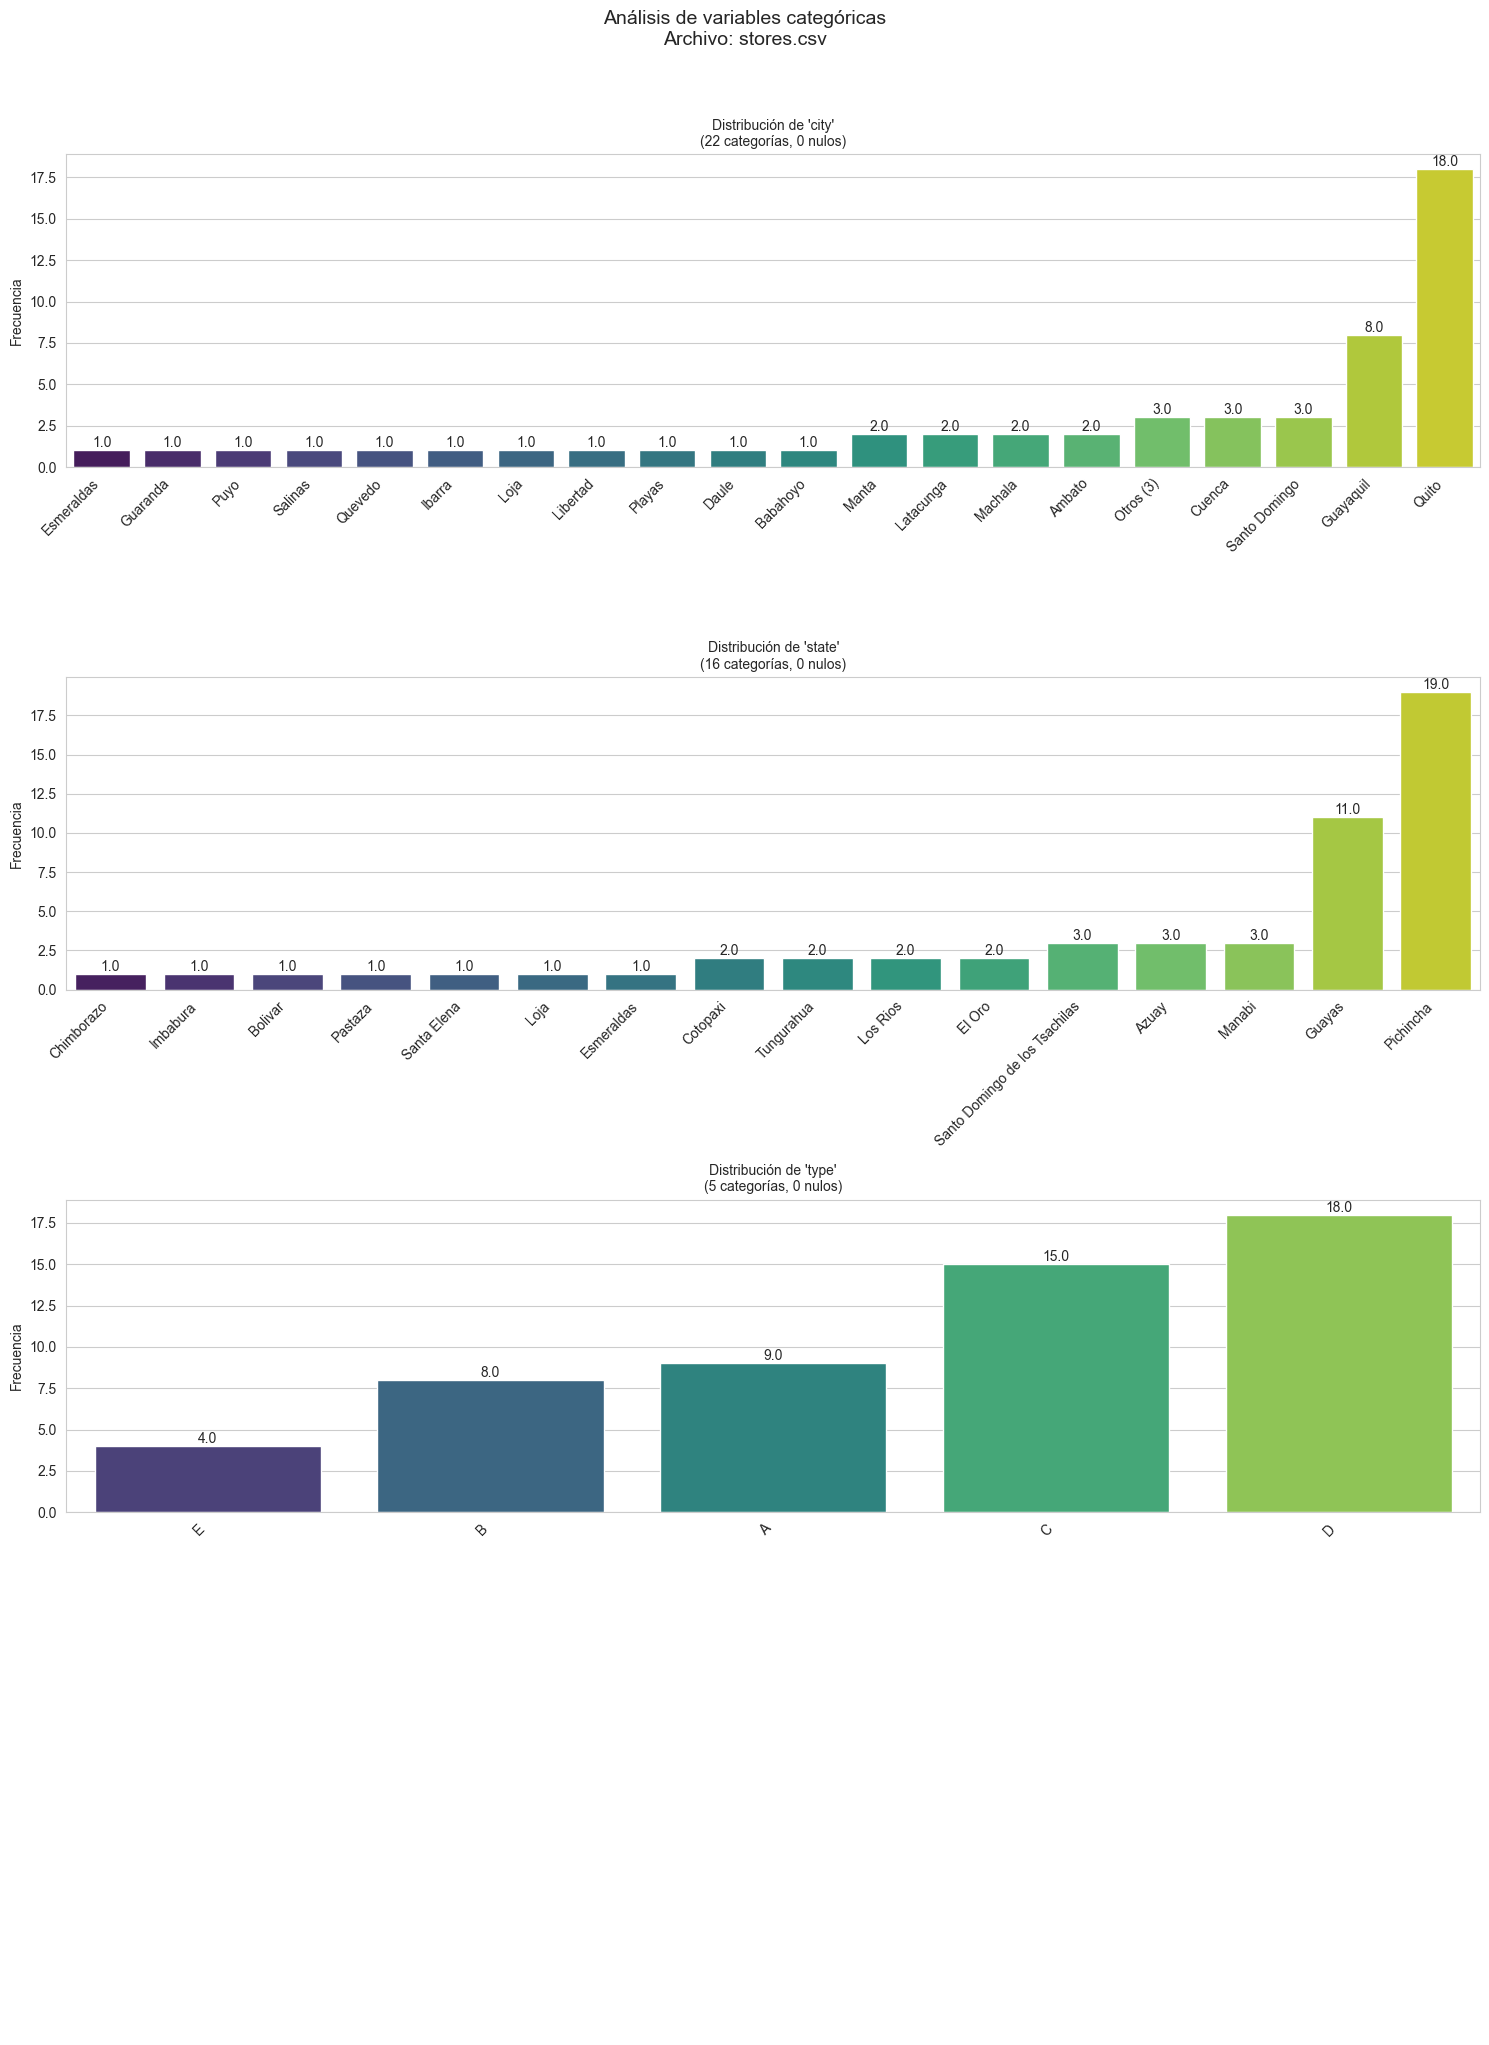

In [28]:
plot_categorical_distribution_from_csv("../data/raw/stores.csv",figsize=(15, 20))


### test

In [40]:
basic_eda( '../data/raw/test.csv')


ANALYZING: ../data/raw/test.csv

File size: 120.32 MB

First 5 rows:


,id,date,store_nbr,item_nbr,onpromotion
0,125497040,2017-08-16,1,96995,False
1,125497041,2017-08-16,1,99197,False
2,125497042,2017-08-16,1,103501,False
3,125497043,2017-08-16,1,103520,False
4,125497044,2017-08-16,1,103665,False



Dimensions: 3370464 rows x 5 columns

Column names and data types:
id              int64
date           object
store_nbr       int64
item_nbr        int64
onpromotion      bool
dtype: object

Basic statistics:
                  id        date     store_nbr      item_nbr onpromotion
count   3.370464e+06     3370464  3.370464e+06  3.370464e+06     3370464
unique           NaN          16           NaN           NaN           2
top              NaN  2017-08-16           NaN           NaN       False
freq             NaN      210654           NaN           NaN     3171867
mean    1.271823e+08         NaN  2.750000e+01  1.244798e+06         NaN
std     9.729693e+05         NaN  1.558579e+01  5.898362e+05         NaN
min     1.254970e+08         NaN  1.000000e+00  9.699500e+04         NaN
25%     1.263397e+08         NaN  1.400000e+01  8.053210e+05         NaN
50%     1.271823e+08         NaN  2.750000e+01  1.294665e+06         NaN
75%     1.280249e+08         NaN  4.100000e+01  1.730015e+0

### train

In [41]:
basic_eda( '../data/raw/train.csv')


ANALYZING: ../data/raw/train.csv

File size: 4765.94 MB

First 5 rows:


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN



Dimensions: 125497040 rows x 6 columns

Column names and data types:
id               int64
date            object
store_nbr        int64
item_nbr         int64
unit_sales     float64
onpromotion     object
dtype: object

Basic statistics:
                  id        date     store_nbr      item_nbr    unit_sales  \
count   1.254970e+08   125497040  1.254970e+08  1.254970e+08  1.254970e+08   
unique           NaN        1684           NaN           NaN           NaN   
top              NaN  2017-07-01           NaN           NaN           NaN   
freq             NaN      118194           NaN           NaN           NaN   
mean    6.274852e+07         NaN  2.746458e+01  9.727692e+05  8.554865e+00   
std     3.622788e+07         NaN  1.633051e+01  5.205336e+05  2.360515e+01   
min     0.000000e+00         NaN  1.000000e+00  9.699500e+04 -1.537200e+04   
25%     3.137426e+07         NaN  1.200000e+01  5.223830e+05  2.000000e+00   
50%     6.274852e+07         NaN  2.800000e+01  9.595000e

In [37]:
train = pd.read_csv("../data/raw/train.csv",nrows=10)

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, List, Literal
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

def plot_time_series(
    file_path: str,
    date_column: str,
    category_column: str,
    value_column: str,
    selected_categories: Optional[List] = None,
    agg_func: Literal['sum', 'mean'] = 'sum',
    date_format: Optional[str] = None,
    title: str = "Análisis de Series de Tiempo",
    figsize: tuple = (16, 8),
    linewidth: float = 2,
    alpha: float = 0.7,
    style: str = 'seaborn',
    palette: str = 'viridis',
    grid: bool = True,
    legend_title: Optional[str] = None,
    x_label: str = "Fecha",
    y_label: Optional[str] = None,
    rot: int = 45,
    **read_csv_kwargs
) -> Optional[pd.DataFrame]:
    """
    Visualiza múltiples series de tiempo a partir de un archivo CSV.
    
    Parámetros:
    -----------
    file_path : str
        Ruta al archivo CSV
    date_column : str
        Nombre de la columna con fechas
    category_column : str
        Nombre de la columna con las categorías
    value_column : str
        Nombre de la columna con los valores numéricos
    selected_categories : list, opcional
        Lista de categorías específicas a incluir. Si es None, incluye todas.
    agg_func : {'sum', 'mean'}, default 'sum'
        Función de agregación para los valores
    date_format : str, opcional
        Formato de fecha si la columna es string (ej: '%Y-%m-%d')
    title : str, opcional
        Título del gráfico
    figsize : tuple, opcional
        Tamaño de la figura (ancho, alto)
    linewidth : float, opcional
        Ancho de las líneas
    alpha : float, opcional
        Transparencia de las líneas
    style : str, opcional
        Estilo de matplotlib
    palette : str, opcional
        Paleta de colores
    grid : bool, opcional
        Mostrar cuadrícula
    legend_title : str, opcional
        Título de la leyenda
    x_label : str, opcional
        Etiqueta del eje X
    y_label : str, opcional
        Etiqueta del eje Y. Si es None, usa el nombre de value_column
    rot : int, opcional
        Rotación de las etiquetas del eje X
    **read_csv_kwargs : dict, opcional
        Argumentos adicionales para pd.read_csv()
        
    Retorna:
    --------
    pd.DataFrame o None
        DataFrame con los datos procesados o None si hubo un error
    """
    try:
        # Leer el archivo
        df = pd.read_csv(file_path,nrows=7000000 , **read_csv_kwargs)
        print(f"Archivo cargado: {file_path}")
        print(f"Registros: {len(df)} | Columnas: {', '.join(df.columns)}")
        df[category_column] = df[category_column].astype(str)
        
        # Verificar columnas requeridas
        required_cols = [date_column, category_column, value_column]
        missing_cols = [col for col in required_cols if col not in df.columns]
        if missing_cols:
            raise ValueError(f"Columnas no encontradas: {', '.join(missing_cols)}")
            
        # Filtrar categorías si se especifican
        if selected_categories is not None:
            available_categories = set(df[category_column].unique())
            selected_set = set(selected_categories)
            
            # Verificar categorías válidas
            invalid_categories = selected_set - available_categories
            if invalid_categories:
                print(f"Advertencia: Las siguientes categorías no existen y serán ignoradas: {', '.join(map(str, invalid_categories))}")
            
            # Filtrar el DataFrame
            
            df = df[df[category_column].isin(selected_set)]
            
            if df.empty:
                raise ValueError("No hay datos para las categorías seleccionadas")
            
            print(f"\nCategorías seleccionadas: {len(selected_set - invalid_categories)} de {len(selected_categories)}")
        else:
            print(f"\nMostrando todas las categorías disponibles")
        
        # Resto del código de procesamiento...
        # Convertir a datetime si es necesario
        if not pd.api.types.is_datetime64_any_dtype(df[date_column]):
            try:
                df[date_column] = pd.to_datetime(df[date_column], format=date_format)
            except Exception as e:
                raise ValueError(f"Error al convertir fechas: {str(e)}")
        
        # Verificar valores numéricos
        if not pd.api.types.is_numeric_dtype(df[value_column]):
            try:
                df[value_column] = pd.to_numeric(df[value_column], errors='raise')
            except Exception as e:
                raise ValueError(f"Error al convertir valores numéricos: {str(e)}")
        
        # Agregar datos
        agg_func = 'sum' if agg_func not in ['sum', 'mean'] else agg_func
        df_agg = df.groupby([date_column, category_column], as_index=False)[value_column].agg(agg_func)
        
        # Pivotar para tener categorías como columnas
        df_pivot = df_agg.pivot(index=date_column, columns=category_column, values=value_column)
        
        # Configurar estilo
        plt.style.use(style)
        plt.figure(figsize=figsize)
        
        # Crear gráfico de líneas
        colors = sns.color_palette(palette, len(df_pivot.columns))
        for i, col in enumerate(df_pivot.columns):
            plt.plot(
                df_pivot.index,
                df_pivot[col],
                label=str(col),
                linewidth=linewidth,
                alpha=alpha,
                color=colors[i]
            )
        
        # Personalizar gráfico
        plt.title(f"{title}\n({agg_func.capitalize()} de {value_column} por {category_column})", 
                 fontsize=14, pad=20)
        plt.xlabel(x_label, fontsize=12)
        plt.ylabel(y_label if y_label else value_column, fontsize=12)
        plt.xticks(rotation=rot)
        
        # Añadir cuadrícula
        if grid:
            plt.grid(True, linestyle='--', alpha=0.7)
        
        # Añadir leyenda
        plt.legend(
            title=legend_title if legend_title else category_column,
            bbox_to_anchor=(1.05, 1),
            loc='upper left'
        )
        
        # Ajustar diseño
        plt.tight_layout()
        plt.show()
        
        # Mostrar estadísticas
        print("\nResumen estadístico:")
        print(f"- Período: {df[date_column].min().date()} a {df[date_column].max().date()}")
        print(f"- Total de {category_column}s: {df[category_column].nunique()}")
        print(f"- Frecuencia de datos: {pd.infer_freq(df_pivot.index) or 'No constante'}")
        print(f"\nEstadísticas de {value_column} (por {category_column}):")
        print(df_pivot.describe().T)
        
   
    except Exception as e:
        print(f"Error al procesar el archivo: {str(e)}")
        return None

In [38]:
train

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN
5,5,2013-01-01,25,108786,3.0,NaN
6,6,2013-01-01,25,108797,1.0,NaN
7,7,2013-01-01,25,108952,1.0,NaN
8,8,2013-01-01,25,111397,13.0,NaN
9,9,2013-01-01,25,114790,3.0,NaN


Archivo cargado: ../data/raw/train.csv
Registros: 7000000 | Columnas: id, date, store_nbr, item_nbr, unit_sales, onpromotion

Categorías seleccionadas: 3 de 3


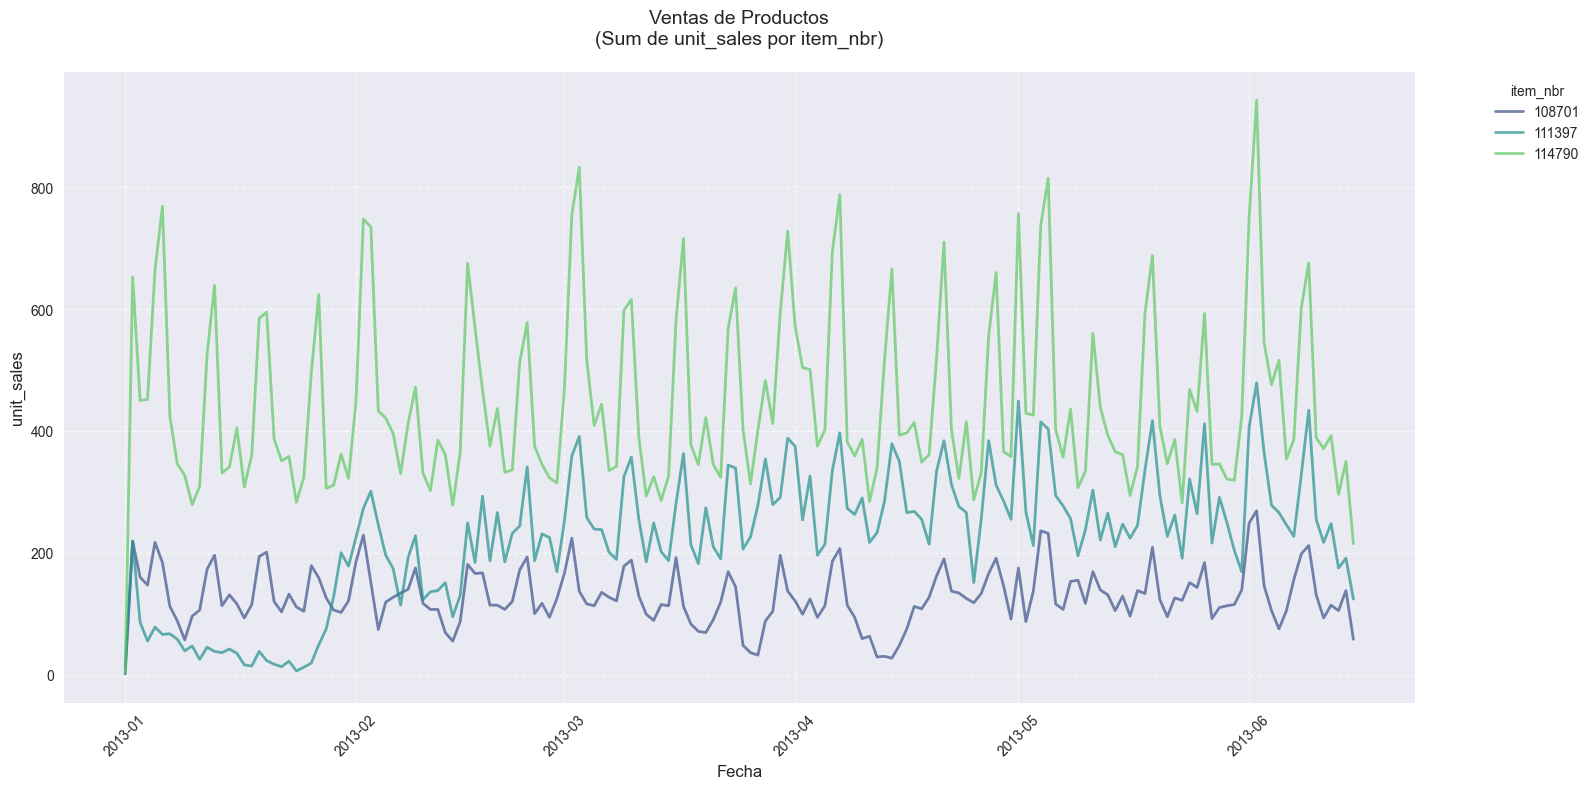


Resumen estadístico:
- Período: 2013-01-01 a 2013-06-15
- Total de item_nbrs: 3
- Frecuencia de datos: D

Estadísticas de unit_sales (por item_nbr):
          count        mean         std  min     25%    50%     75%    max
item_nbr                                                                  
108701    166.0  128.445783   46.790637  1.0  104.00  121.0  155.75  269.0
111397    166.0  224.072289  108.301967  6.0  179.00  235.5  284.75  479.0
114790    166.0  446.445783  148.060000  3.0  342.75  399.0  524.25  943.0


In [56]:
categorias_interes = ["111397", "108701", "114790"]
plot_time_series(
    file_path="../data/raw/train.csv",
    date_column="date",
    category_column="item_nbr",
    value_column="unit_sales",
    selected_categories=categorias_interes,
    title="Ventas de Productos"
    
)

Archivo cargado: ../data/raw/transactions.csv
Registros: 2000 | Columnas: date, store_nbr, transactions
Advertencia: Las siguientes categorías no existen y serán ignoradas: 22

Categorías seleccionadas: 2 de 3


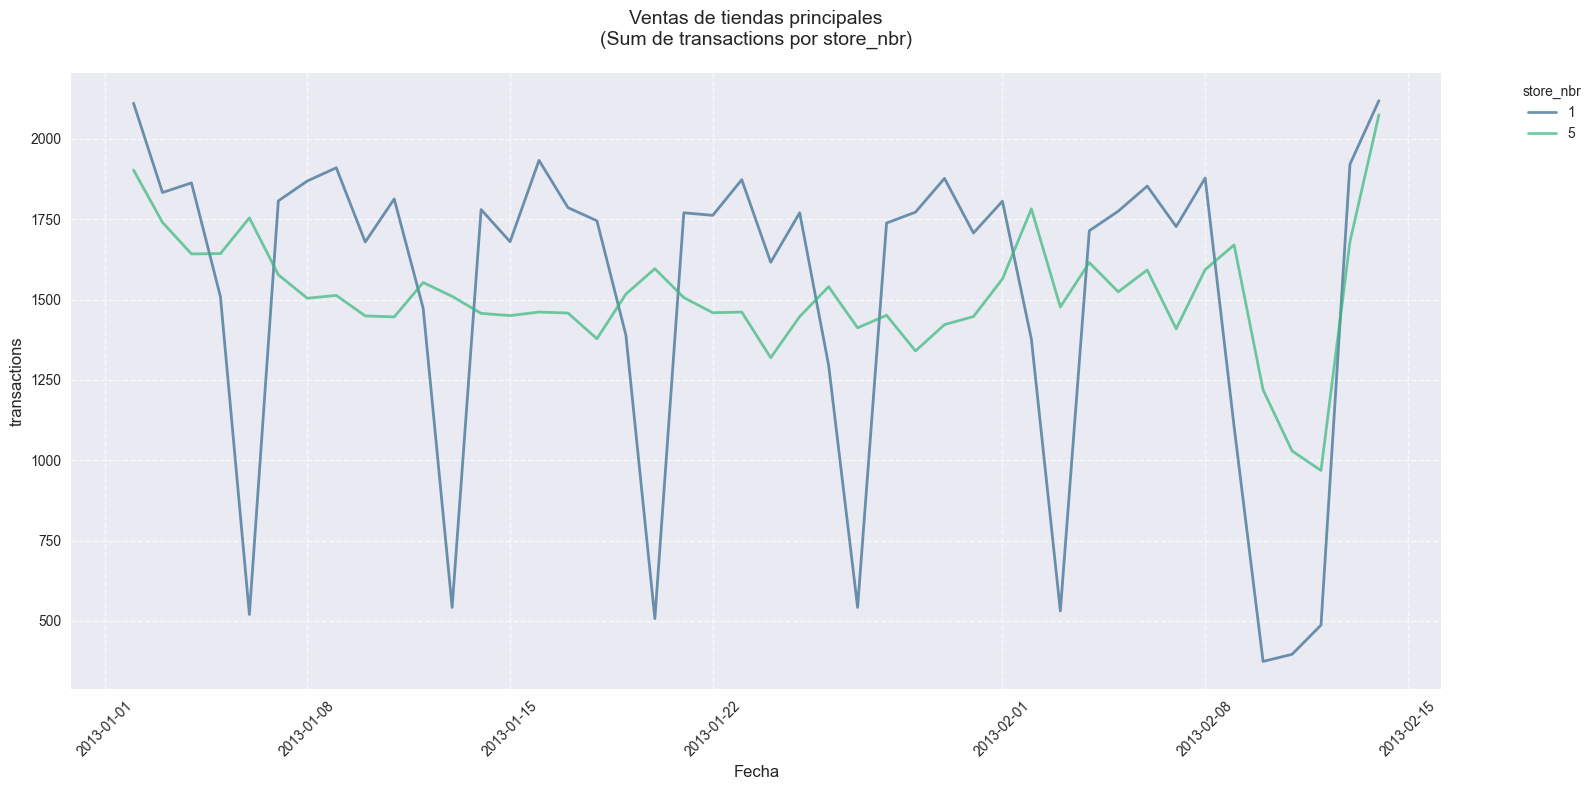


Resumen estadístico:
- Período: 2013-01-02 a 2013-02-14
- Total de store_nbrs: 2
- Frecuencia de datos: D

Estadísticas de transactions (por store_nbr):
           count         mean         std    min     25%     50%      75%  \
store_nbr                                                                   
1           44.0  1512.113636  524.208560  374.0  1386.0  1753.5  1838.00   
5           44.0  1512.545455  189.792844  968.0  1447.0  1505.0  1593.75   

              max  
store_nbr          
1          2119.0  
5          2075.0  


In [53]:
categorias_interes = ["1", "5", "22"]
plot_time_series(
    file_path="../data/raw/transactions.csv",
    date_column="date",
    category_column="store_nbr",
    value_column="transactions",
    selected_categories=categorias_interes,
    title="Ventas de tiendas principales"
    
)

### transactions

In [42]:
basic_eda( '../data/raw/transactions.csv')


ANALYZING: ../data/raw/transactions.csv

File size: 1.48 MB

First 5 rows:


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922



Dimensions: 83488 rows x 3 columns

Column names and data types:
date            object
store_nbr        int64
transactions     int64
dtype: object

Basic statistics:
              date     store_nbr  transactions
count        83488  83488.000000  83488.000000
unique        1682           NaN           NaN
top     2017-08-15           NaN           NaN
freq            54           NaN           NaN
mean           NaN     26.939237   1694.602158
std            NaN     15.608204    963.286644
min            NaN      1.000000      5.000000
25%            NaN     13.000000   1046.000000
50%            NaN     27.000000   1393.000000
75%            NaN     40.000000   2079.000000
max            NaN     54.000000   8359.000000

Missing values per column:
date            0
store_nbr       0
transactions    0
dtype: int64


In [28]:
train = pd.read_csv("../data/raw/train.csv")
train = train[train['store_nbr'].isin([3, 4, 6, 7, 8, 44, 45, 46, 47, 48, 49])]

C:\Users\richa\AppData\Local\Temp\ipykernel_3452\2407974958.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("../data/raw/train.csv")


In [29]:
start_date = pd.to_datetime('2017-01-01')
end_date = pd.to_datetime('2017-08-15')

train['date'] = pd.to_datetime(train['date'])
train = train[(train['date'] >= start_date) & (train['date'] <= end_date)]

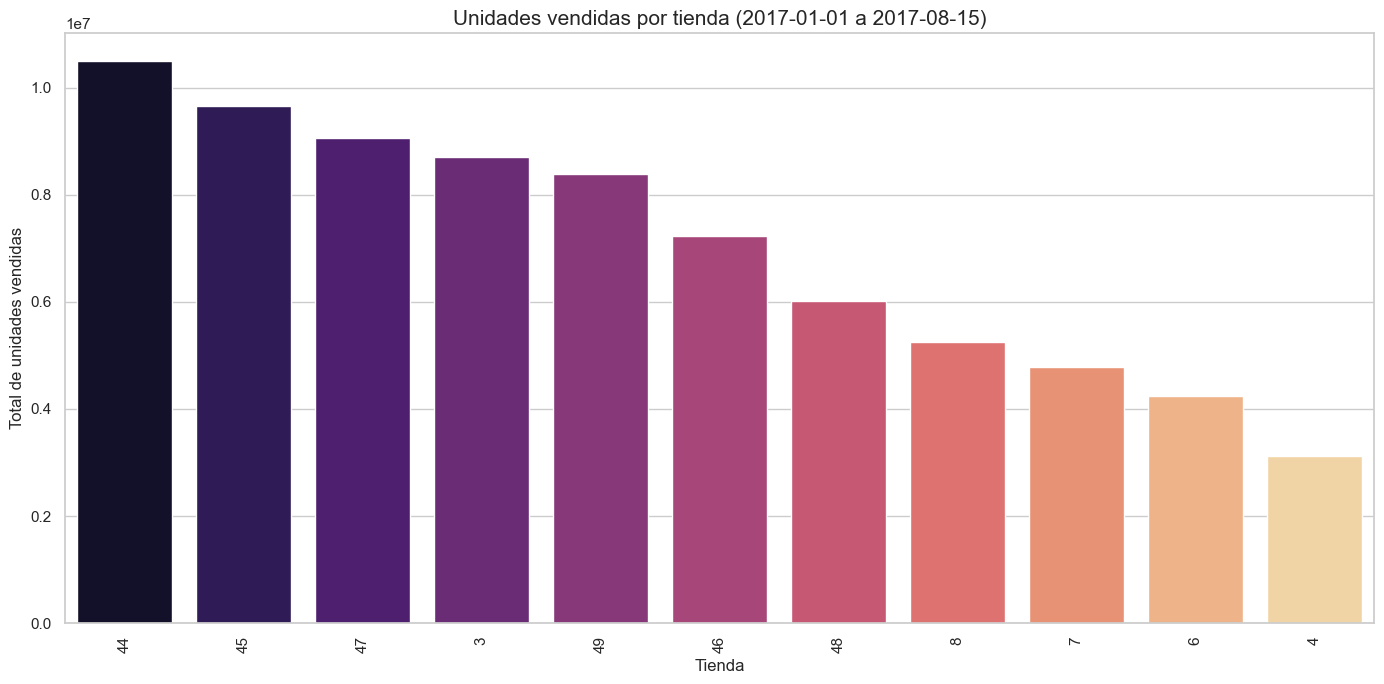

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Agrupar por tienda y sumar las unidades vendidas
ventas_por_tienda = train.groupby('store_nbr')['unit_sales'].sum().reset_index()

# Ordenar de mayor a menor
ventas_por_tienda = ventas_por_tienda.sort_values(by='unit_sales', ascending=False)

# Estilo moderno
sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 7))
palette = sns.color_palette("magma", len(ventas_por_tienda))

# Gráfico de barras
sns.barplot(
    x='store_nbr',
    y='unit_sales',
    data=ventas_por_tienda,
    palette=palette,
    order=ventas_por_tienda['store_nbr']
)

# Etiquetas y título
plt.xlabel("Tienda", fontsize=12)
plt.ylabel("Total de unidades vendidas", fontsize=12)
plt.title("Unidades vendidas por tienda (2017-01-01 a 2017-08-15)", fontsize=15)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [30]:
promocion = train[train["onpromotion"] == True]

In [36]:
most_sold_items = promocion.groupby("item_nbr").size().sort_values(ascending=False)[:10]
most_sold_items

item_nbr
1986627    1368
849142     1345
849095     1308
959502     1302
1157329    1244
1986500    1236
651523     1217
1930967    1215
2014085    1188
1457185    1182
dtype: int64

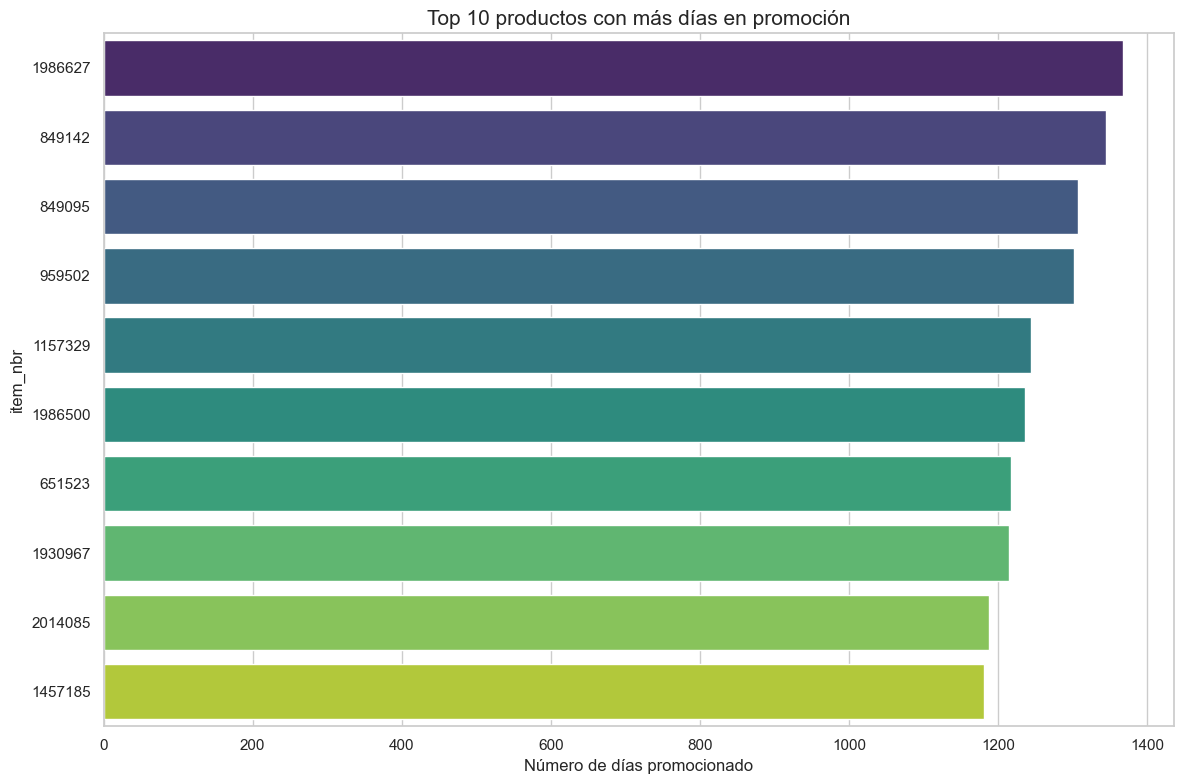

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Datos
data = {
    'item_nbr': [
        1986627, 849142, 849095, 959502, 1157329, 1986500, 651523, 1930967,
        2014085, 1457185
    ],
    'promo_days': [
        1368, 1345, 1308, 1302, 1244, 1236, 1217, 1215, 1188, 1182
    ]
}

# Crear DataFrame
df = pd.DataFrame(data)

# Ordenar de mayor a menor
df_sorted = df.sort_values(by='promo_days', ascending=False)

# Convertir item_nbr a categoría ordenada para el gráfico
df_sorted['item_nbr'] = df_sorted['item_nbr'].astype(str)  # opcional: más legible en eje Y
df_sorted['item_nbr'] = pd.Categorical(df_sorted['item_nbr'], categories=df_sorted['item_nbr'], ordered=True)

# Estilo moderno
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
palette = sns.color_palette("viridis", len(df_sorted))

# Gráfico de barras horizontales
sns.barplot(
    x='promo_days',
    y='item_nbr',
    data=df_sorted,
    palette=palette
)

# Etiquetas y títulos
plt.xlabel("Número de días promocionado", fontsize=12)
plt.ylabel("item_nbr", fontsize=12)
plt.title("Top 10 productos con más días en promoción", fontsize=15)
plt.tight_layout()

plt.show()


In [34]:
df_sorted

,item_nbr,promo_days
0,1986627,1368
1,849142,1345
2,849095,1308
3,959502,1302
4,1157329,1244
5,1986500,1236
6,651523,1217
7,1930967,1215
8,2014085,1188
9,1457185,1182


In [40]:
most_sold_items = train.groupby("item_nbr").size().sort_values(ascending=False)[:10].index


In [16]:
items = pd.read_csv("../data/raw/items.csv")

In [41]:
items[items['item_nbr'].isin(most_sold_items)]

,item_nbr,family,class,perishable
337,320682,GROCERY I,1080,0
706,582864,MEATS,2302,1
1425,1036689,GROCERY I,1040,0
1757,1162382,GROCERY I,1022,0
1965,1239901,POULTRY,2420,1
2726,1473394,PRODUCE,2006,1
2730,1473403,PRODUCE,2010,1
2737,1473412,PRODUCE,2032,1
2744,1473474,PRODUCE,2014,1
3444,1978835,BREAD/BAKERY,2708,1


In [23]:
stores = pd.read_csv("../data/raw/stores.csv")

In [24]:
stores = stores[stores['store_nbr'].isin([3, 4, 6, 7, 8, 44, 45, 46, 47, 48, 49])]

In [25]:
stores

,store_nbr,city,state,type,cluster
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
43,44,Quito,Pichincha,A,5
44,45,Quito,Pichincha,A,11
45,46,Quito,Pichincha,A,14
46,47,Quito,Pichincha,A,14
47,48,Quito,Pichincha,A,14
